In [72]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import scipy.stats as stats
from math import pi
from seaborn import kdeplot

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble  import RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Conv1D, MaxPooling1D, Flatten

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_columns', 200)

In [4]:
df = pd.read_csv("male_players (legacy)_23.csv")

In [5]:
df.head(5)

,player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,league_id,league_name,league_level,club_team_id,club_name,club_position,club_jersey_number,club_loaned_from,club_joined_date,club_contract_valid_until_year,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url
0,158023,/player/158023/lionel-messi/150002,15,2,2014-09-18,L. Messi,Lionel Andrés Messi Cuccittini,CF,93,95,100500000.0,550000.0,27,1987-06-24,169,67,53.0,La Liga,1.0,241.0,FC Barcelona,CF,10.0,NaN,2004-07-01,2018.0,52,Argentina,1369.0,CF,10.0,Left,3,4,5,Medium/Low,Normal (170-),Yes,NaN,"#Speedster, #Dribbler, #FK Specialist, #Acroba...","Finesse Shot, Speed Dribbler (AI), One Club Pl...",93.0,89.0,86.0,96.0,27.0,63.0,84,94,71,89,85,96,89,90,76,96,96,90,94,94,95,80,73,77,60,88,48,22,92,90,76,NaN,25,21,20,6,11,15,14,8,NaN,89+3,89+3,89+3,92+3,90+3,90+3,90+3,92+3,92+3,92+3,92+3,90+3,79+3,79+3,79+3,90+3,62+3,62+3,62+3,62+3,62+3,54+3,45+3,45+3,45+3,54+3,15+3,https://cdn.sofifa.net/players/158/023/15_120.png
1,20801,/player/20801/c-ronaldo-dos-santos-aveiro/150002,15,2,2014-09-18,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"LW, LM",92,92,79000000.0,375000.0,29,1985-02-05,185,80,53.0,La Liga,1.0,243.0,Real Madrid CF,LW,7.0,NaN,2009-07-01,2018.0,38,Portugal,1354.0,LW,7.0,Right,4,5,5,High/Low,Normal (185+),Yes,NaN,"#Speedster, #Dribbler, #Distance Shooter, #Acr...","Power Free-Kick, Flair, Long Shot Taker (AI), ...",93.0,93.0,81.0,91.0,32.0,79.0,83,95,86,82,87,93,88,79,72,92,91,94,93,90,63,94,94,89,79,93,63,24,91,81,85,NaN,22,31,23,7,11,15,14,11,NaN,91+1,91+1,91+1,89+3,91+1,91+1,91+1,89+3,89+3,89+3,89+3,87+3,77+3,77+3,77+3,87+3,63+3,63+3,63+3,63+3,63+3,57+3,52+3,52+3,52+3,57+3,16+3,https://cdn.sofifa.net/players/020/801/15_120.png
2,9014,/player/9014/arjen-robben/150002,15,2,2014-09-18,A. Robben,Arjen Robben,"RM, LM, RW",90,90,54500000.0,275000.0,30,1984-01-23,180,80,19.0,Bundesliga,1.0,21.0,FC Bayern München,SUB,10.0,NaN,2009-08-28,2017.0,34,Netherlands,105035.0,RS,11.0,Left,2,4,5,High/Low,Normal (170-185),Yes,NaN,"#Speedster, #Dribbler, #Distance Shooter, #Acr...","Diver, Injury Prone, Avoids Using Weaker Foot,...",93.0,86.0,83.0,92.0,32.0,64.0,80,85,50,86,86,93,85,83,76,90,93,93,93,89,91,86,61,78,65,90,47,39,89,84,80,NaN,29,26,26,10,8,11,5,15,NaN,84+3,84+3,84+3,88+2,87+3,87+3,87+3,88+2,88+2,88+2,88+2,87+3,78+3,78+3,78+3,87+3,64+3,64+3,64+3,64+3,64+3,55+3,46+3,46+3,46+3,55+3,14+3,https://cdn.sofifa.net/players/009/014/15_120.png
3,41236,/player/41236/zlatan-ibrahimovic/150002,15,2,2014-09-18,Z. Ibrahimović,Zlatan Ibrahimović,ST,90,90,52500000.0,275000.0,32,1981-10-03,195,95,16.0,Ligue 1,1.0,73.0,Paris Saint-Germain,ST,10.0,NaN,2012-07-01,2016.0,46,Sweden,1363.0,ST,10.0,Right,4,4,5,Medium/Low,Normal (185+),Yes,NaN,"#Poacher, #Aerial Threat, #Distance Shooter, #...","Power Free-Kick, Leadership, Flair, Long Shot ...",76.0,91.0,81.0,86.0,34.0,86.0,76,91,76,84

In [6]:
# Drop columns because they contain urls which are not useful for our tas and fifa_update has only one value.
df = df.drop(['player_url', 'player_face_url', 'fifa_update'], axis=1)

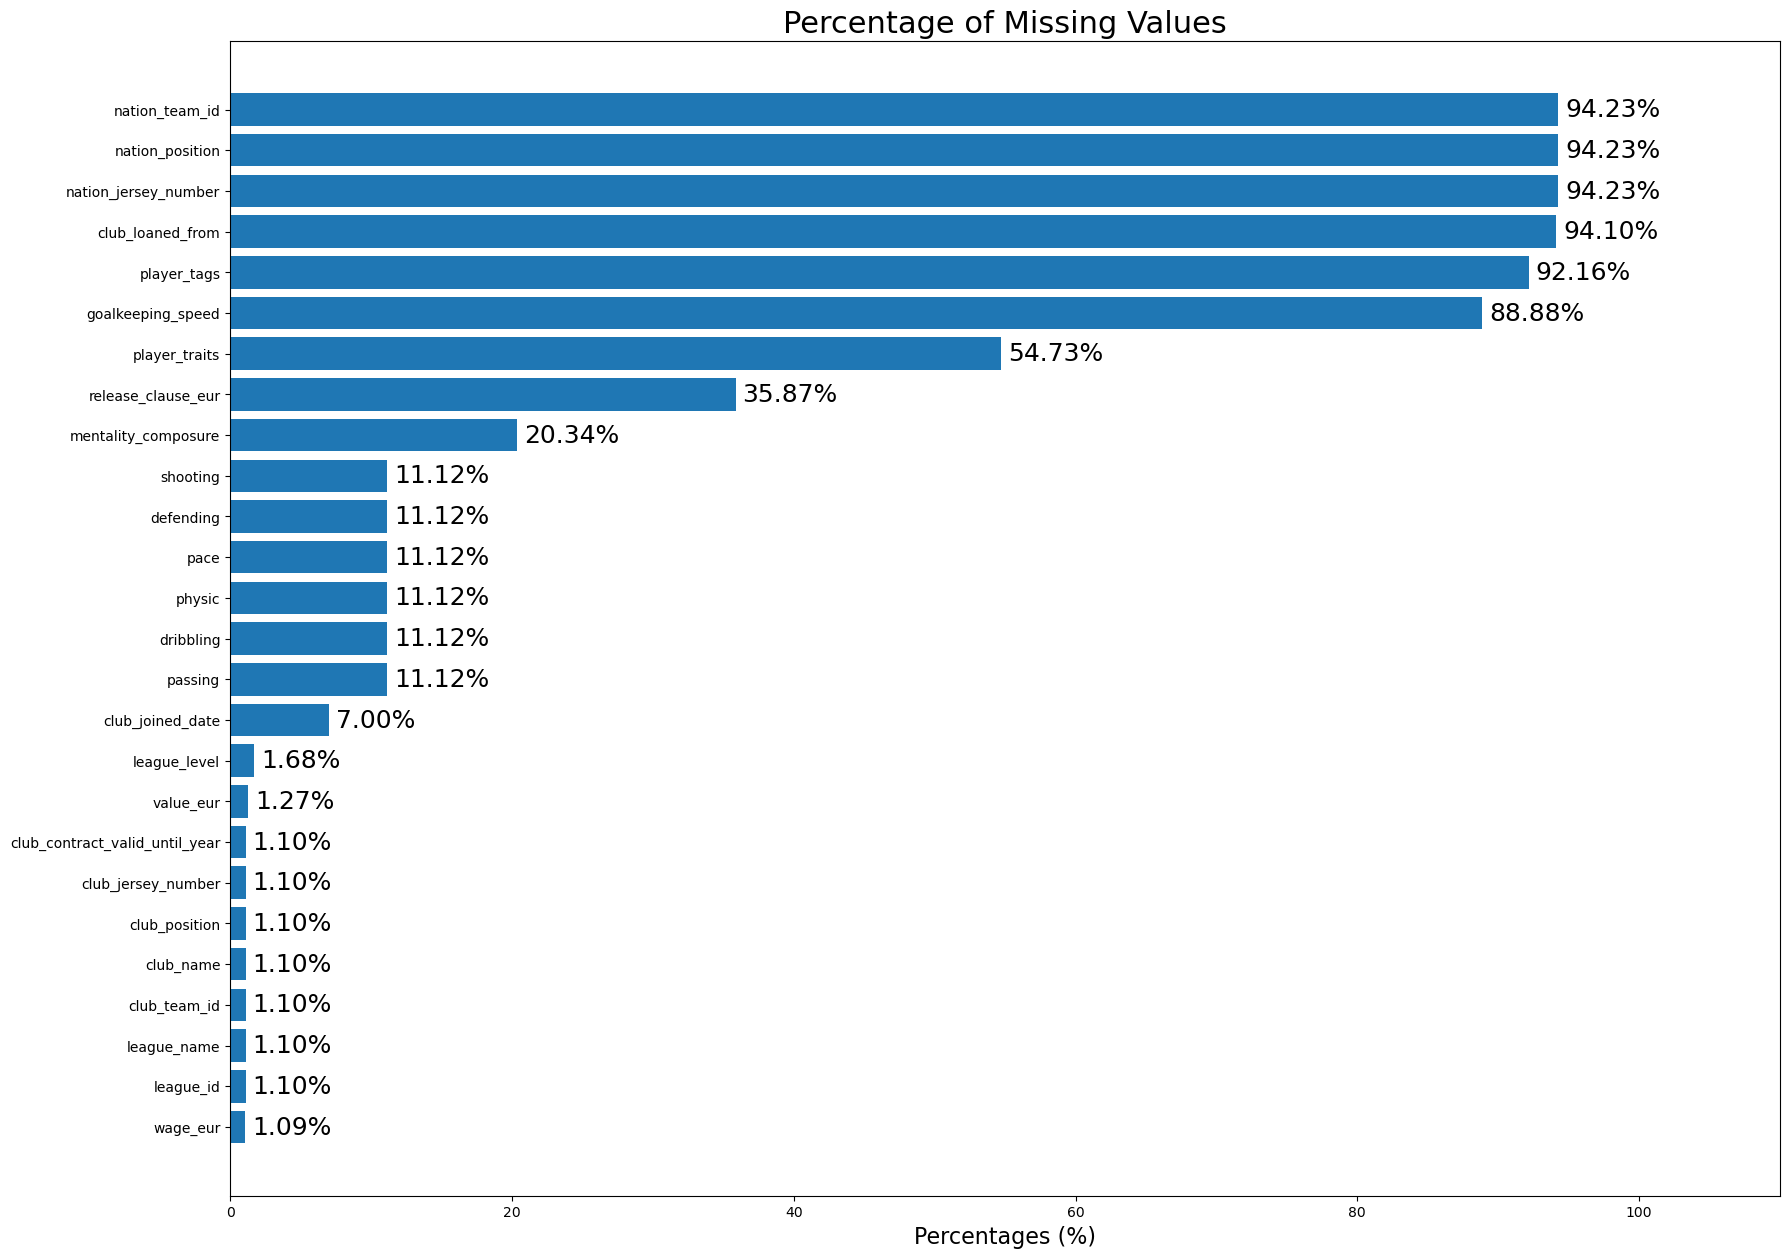

In [7]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(20, 15))
ax.barh(missing_percentage.index, missing_percentage)

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 110])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [8]:
# Step 1: Remove columns with more than 20% null values
missing_percentage = (df.isnull().sum() / len(df)) * 100
columns_to_remove = missing_percentage[missing_percentage >= 20].index
df = df.drop(columns=columns_to_remove)

# Step 2: Drop rows with null values from columns containing 10% or less null values
columns_to_keep = missing_percentage[missing_percentage <= 10].index
df = df.dropna(subset=columns_to_keep)

# Step 3: Impute remaining columns with mean values
columns_to_impute = df.columns[df.isnull().any()]
for column in columns_to_impute:
    df[column] = df[column].fillna(df[column].mean())

# Optionally, you may want to reset the index if rows were removed
df = df.reset_index(drop=True)

In [9]:
# Convert columns to datetime and extract year in new columns
# For these dates only year is more valueable than month and days
df['fifa_update_year'] = pd.to_datetime(df['fifa_update_date']).dt.year.astype('int64')
df['birth_year'] = pd.to_datetime(df['dob']).dt.year.astype('int64')
df['club_joined_year'] = pd.to_datetime(df['club_joined_date']).dt.year.astype('int64')

# Drop original columns
df = df.drop(['fifa_update_date', 'dob', 'club_joined_date'], axis=1)

In [10]:
columns = ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk']

# Step 1: Split the values into base value and modifier
def split_and_convert(value):
    # Check if the value contains a '+'
    value = str(value)
    if '+' in value:
        parts = value.split('+')
        base = int(parts[0])
        modifier = int(parts[1])
        return base, modifier
    # Check if the value contains a '-'
    elif '-' in value:
        parts = value.split('-')
        base = int(parts[0])
        modifier = -int(parts[1])
        return base, modifier
    # Convert other values to integers
    else:
        return int(value), 0

#  These columns contains a base value and a modifier added or subtracted from it 
#  We separated base and modifier and converted to int 
for col in columns:
    df[col+'_base'], df[col+'_modifier'] = zip(*df[col].apply(split_and_convert))

# Step 3: Calculate the total value from base and modifier 
for col in columns:
    df[col] = df[col+'_base'] + df[col+'_modifier']

#Step 4: Drop the original columns and keep only the total values
columns_to_drop = df.columns[df.columns.str.contains('_base|_modifier')]
df = df.drop(columns_to_drop, axis=1)

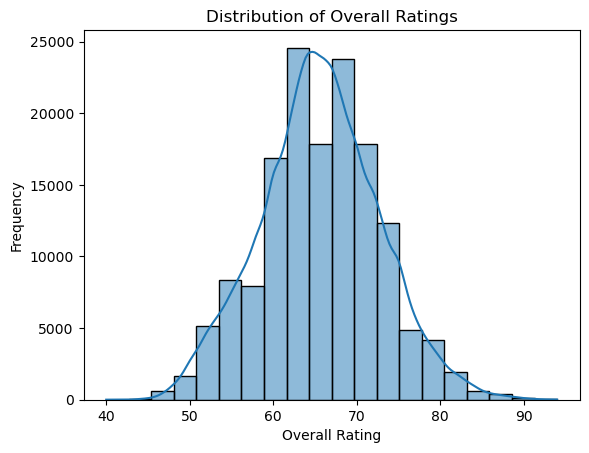

In [11]:
# Histograms
sns.histplot(df['overall'], bins=20, kde=True)

# Add labels and title
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Overall Ratings')

# Show the plot
plt.show()

**The distribution of overall ratings**

The distribution of overall ratings for players appears to follow a roughly normal distribution, with the majority of ratings clustering around 60 to 70. This indicates that most players have average ratings, with fewer players achieving very high or very low overall ratings. This bell-shaped curve suggests a balanced distribution of player abilities within the dataset.

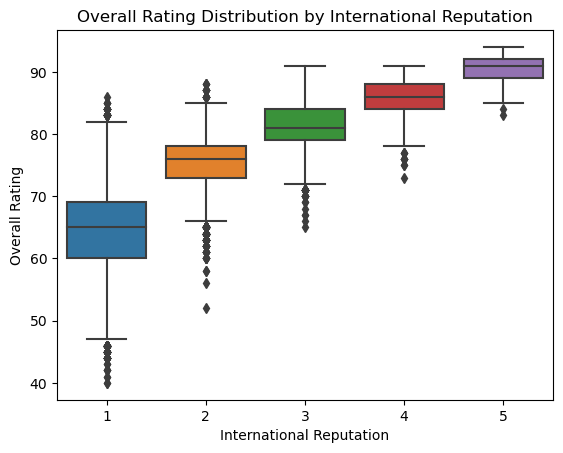

In [12]:
# Box plots of Rating with international reputation
sns.boxplot(x='international_reputation', y='overall', data=df)
plt.xlabel('International Reputation')
plt.ylabel('Overall Rating')
plt.title('Overall Rating Distribution by International Reputation')
plt.show()

**Overall Rating with International Reputation**

The boxplot illustrates that players with higher international reputations tend to have higher overall ratings. As the international reputation increases from 1 to 5, the median and range of overall ratings also increase. This suggests a strong positive correlation between a player's international reputation and their overall rating.

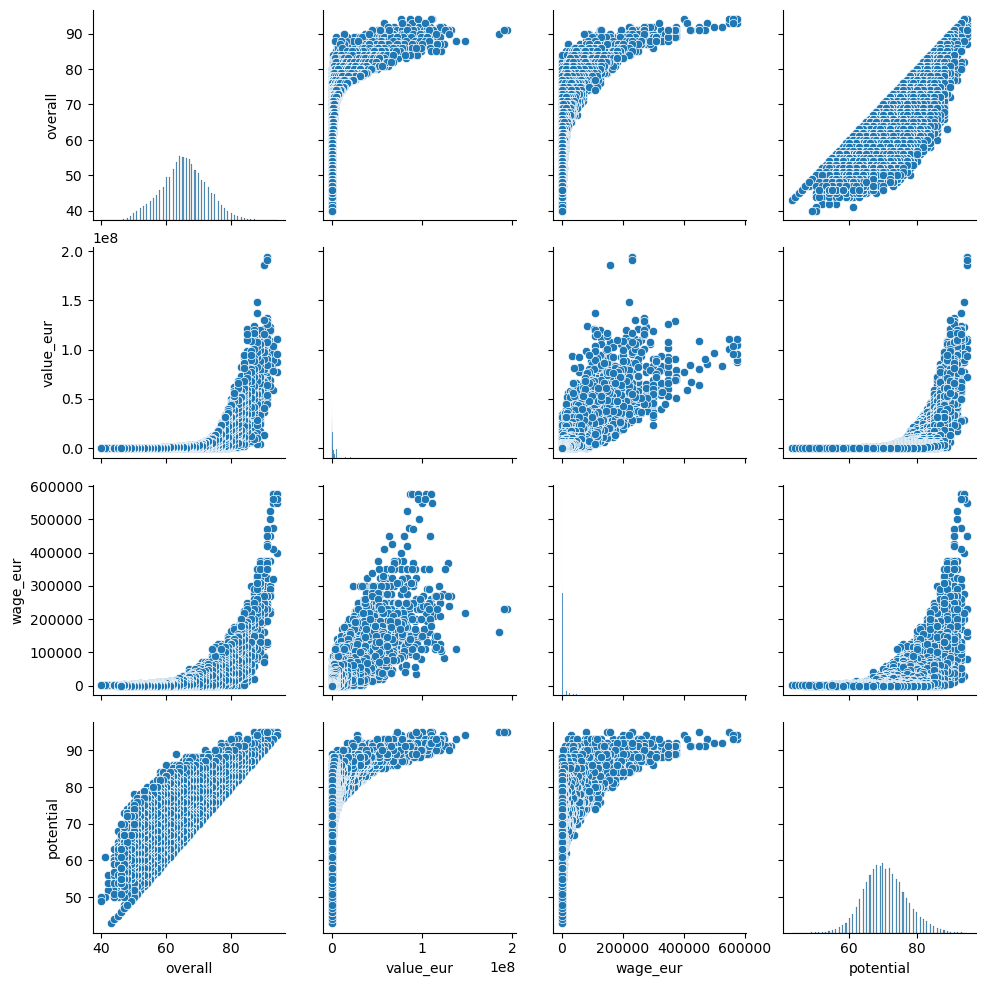

In [13]:
# Pair plots
sns.pairplot(df[['overall', 'value_eur', 'wage_eur', 'potential']])
plt.show()

**Pair Plot**

The pairplot provides several insights into the relationships between overall rating, value in euros, wage in euros, and potential. There is a strong positive correlation between overall rating and potential, as indicated by the dense cluster of points along the diagonal line. Both overall rating and potential show a logarithmic relationship with value and wage, where higher values in these attributes correspond to higher wages and market values, but with diminishing returns at the upper end. Additionally, the scatter plots highlight that there are fewer players with extremely high wages and values, which are outliers in the dataset. The histograms along the diagonal give a sense of the distribution of each variable, showing that most players have mid-range overall ratings and potential.

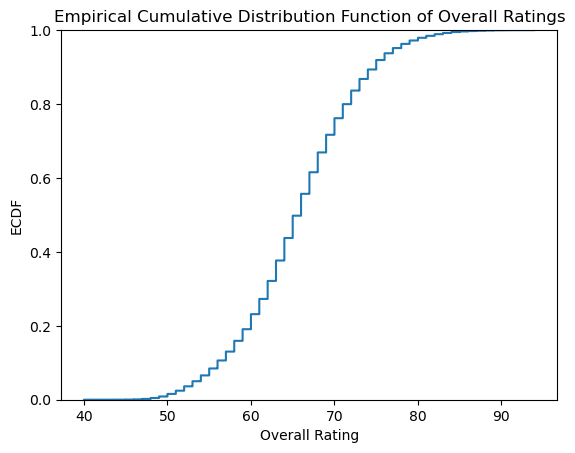

In [14]:
# ECDF plot
sns.ecdfplot(data=df, x='overall')
plt.xlabel('Overall Rating')
plt.ylabel('ECDF')
plt.title('Empirical Cumulative Distribution Function of Overall Ratings')
plt.show()

**Empirical Cummulative Distribution of Overall Rating**

The Empirical Cumulative Distribution Function (ECDF) plot shows the cumulative probability distribution of players' overall ratings. The curve indicates that ratings are roughly normally distributed, with a significant increase between ratings of 50 and 80, where the majority of players fall. Approximately 50% of the players have an overall rating below 70, while almost all players have ratings below 90. This plot effectively highlights the distribution spread and central tendency of the overall ratings among the players.

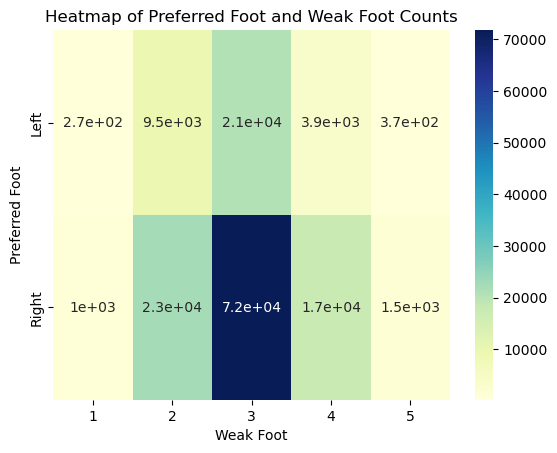

In [15]:
# Create a cross-tabulation of preferred_foot and weak_foot
cross_tab = pd.crosstab(df['preferred_foot'], df['weak_foot'])

# Create a heatmap using seaborn
sns.heatmap(cross_tab, annot=True, cmap="YlGnBu")
plt.xlabel('Weak Foot')
plt.ylabel('Preferred Foot')
plt.title('Heatmap of Preferred Foot and Weak Foot Counts')
plt.show()


The heatmap displays the relationship between players' preferred foot and the ratings of their weak foot. The most common combination is players with a right preferred foot and a weak foot rating of 3, indicated by the darkest blue cell representing a count of 72,000. In contrast, players with a left preferred foot and a weak foot rating of 5 are the least common, shown by the lightest cells with counts as low as 370. Overall, the data shows a higher prevalence of right-footed players across all weak foot ratings, with moderate ratings (2 and 3) being the most frequent for both left and right-footed players.

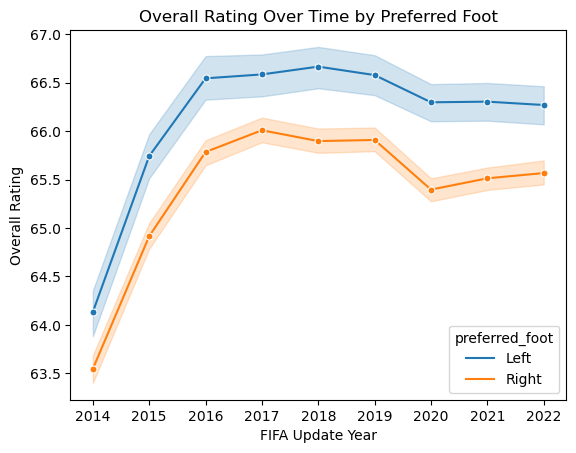

In [16]:
# Radial plots
sns.lineplot(data=df, x='fifa_update_year', y='overall', hue='preferred_foot', marker='o', markersize=5)
plt.xlabel('FIFA Update Year')
plt.ylabel('Overall Rating')
plt.title('Overall Rating Over Time by Preferred Foot')
plt.show()

The provided data shows the average overall rating for soccer players by their preferred foot. Left footed players have a slightly higher average rating than right footed players. However, the difference is minimal. 

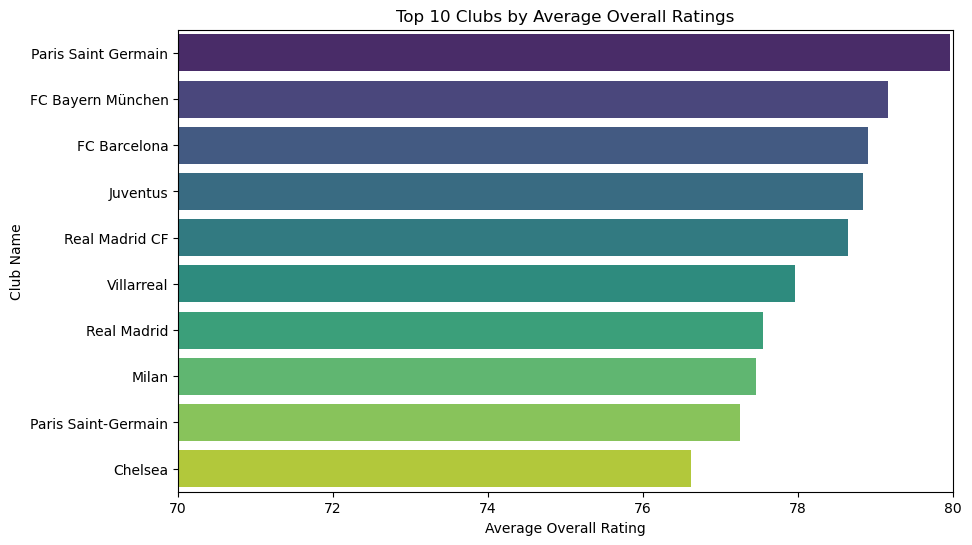

In [17]:
# 5. Barplot of Top 10 Clubs by Overall Ratings
top_clubs = df.groupby('club_name')['overall'].mean().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_clubs.values, y=top_clubs.index, palette='viridis')
plt.xlabel('Average Overall Rating')
plt.ylabel('Club Name')
plt.title('Top 10 Clubs by Average Overall Ratings')
plt.xlim(70, 80)  # Set x-axis limits
plt.show()

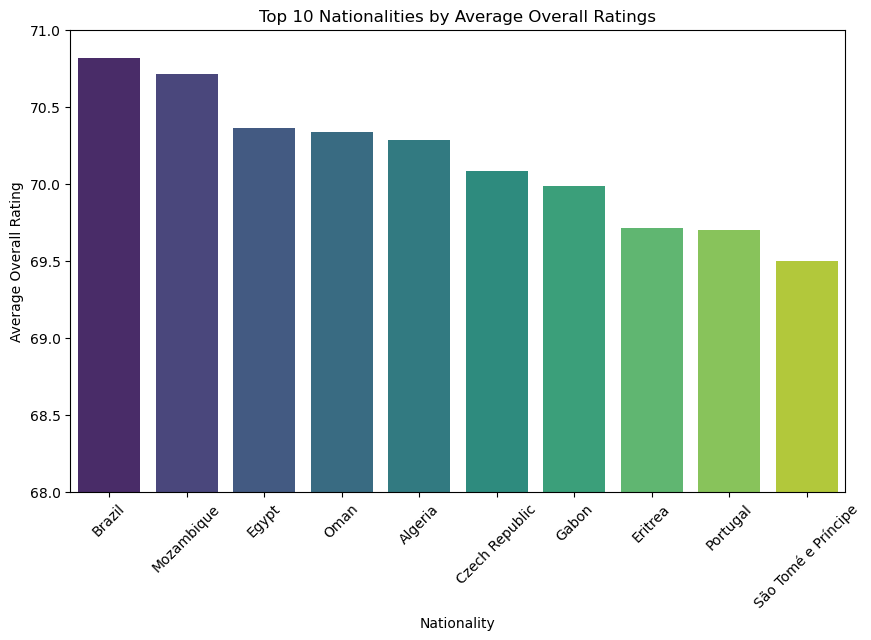

In [18]:
# 15. Barplot of Top 10 Nationalities by Overall Ratings
top_nationalities = df.groupby('nationality_name')['overall'].mean().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_nationalities.index, y=top_nationalities.values, palette='viridis')
plt.xlabel('Nationality')
plt.ylabel('Average Overall Rating')
plt.title('Top 10 Nationalities by Average Overall Ratings')
plt.ylim(68, 71)  # Set y-axis limits
plt.xticks(rotation=45)
plt.show()

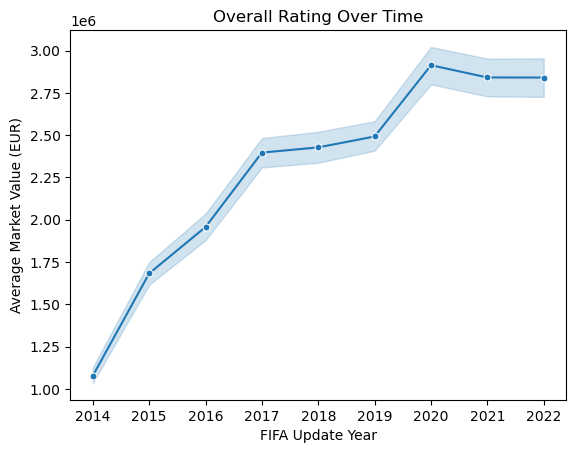

In [19]:
sns.lineplot(data=df, x='fifa_update_year', y='value_eur', marker='o', markersize=5)
plt.xlabel('FIFA Update Year')
plt.ylabel('Average Market Value (EUR)')
plt.title('Overall Rating Over Time')
plt.show()

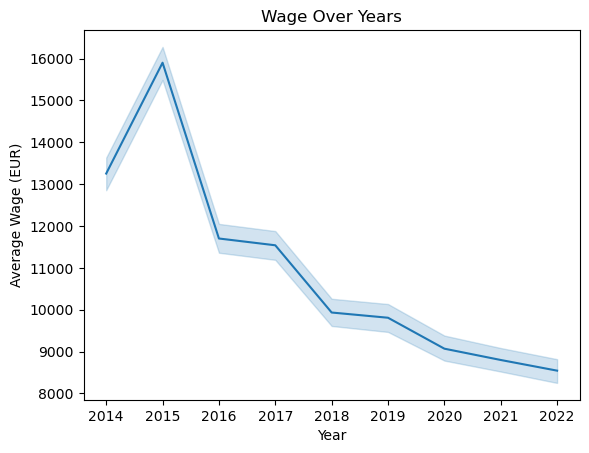

In [20]:
# Time Series of Wage Over Years
sns.lineplot(x='fifa_update_year', y='wage_eur', data=df)
plt.xlabel('Year')
plt.ylabel('Average Wage (EUR)')
plt.title('Wage Over Years')
plt.show()

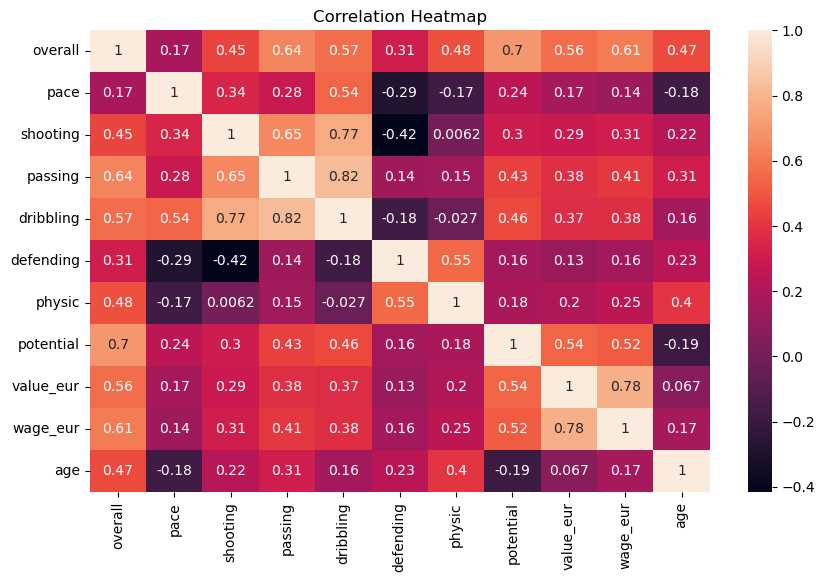

In [21]:
# 2. Correlation Matrix of Key Player Attributes
plt.figure(figsize=(10, 6))
sns.heatmap(df[['overall', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'potential', 'value_eur', 'wage_eur', 'age']].corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()

Based on the heatmap, there appears to be a positive correlation between physical attributes and defending skill in soccer players. Players with higher values in physic tend to also have higher defending ratings. Similarly, there seems to be a positive correlation between pace and dribbling, and between shooting and passing. 

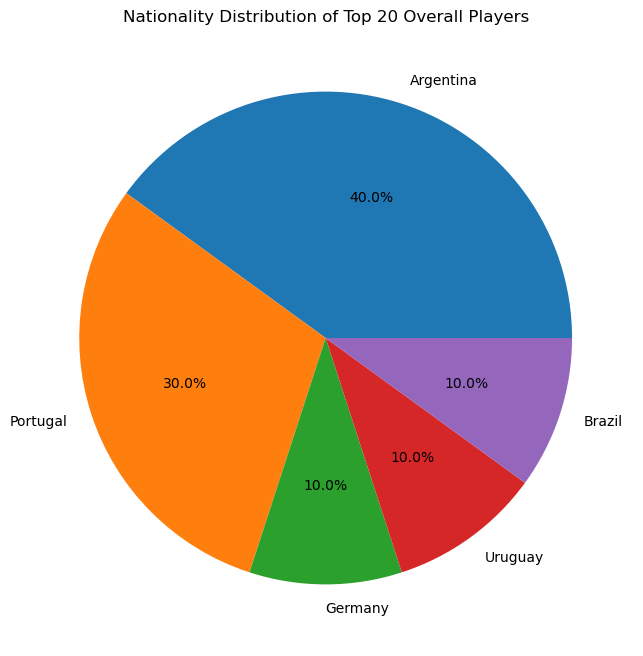

In [22]:
# 5. Nationality Distribution of Top 10 Overall Players
top_10_players = df.nlargest(20, 'overall')
nationality_counts = top_10_players['nationality_name'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(nationality_counts, labels=nationality_counts.index, autopct='%1.1f%%')
plt.title('Nationality Distribution of Top 20 Overall Players')
plt.show()

The plot displays the nationality distribution of the top 20 players worldwide, revealing Argentina as the dominant source with 40% representation. Portugal follows closely behind with 30%, while Germany, Uruguay, and Brazil each contribute 10%. This visualization offers a concise snapshot of the geographical diversity among elite players.

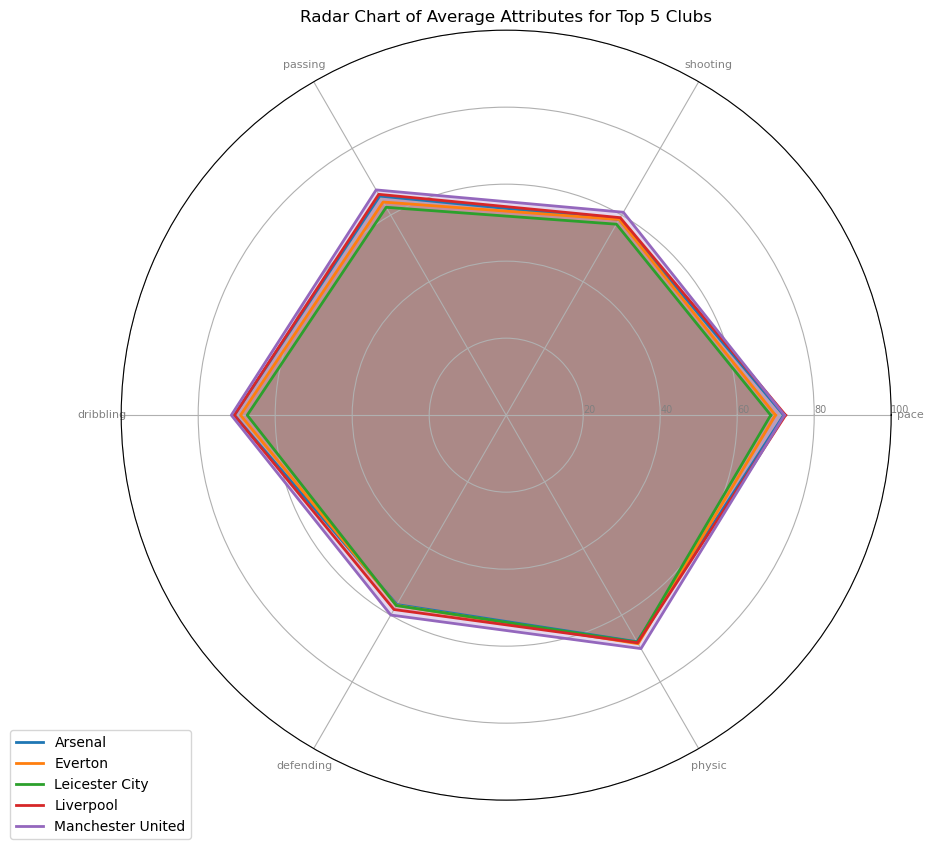

In [23]:
# Average attributes for top 5 clubs
top_clubs = df['club_name'].value_counts().nlargest(5).index
attributes = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']

radar_data = df[df['club_name'].isin(top_clubs)].groupby('club_name')[attributes].mean()

# Radar chart setup
categories = list(radar_data.columns)
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

for club in radar_data.index:
    values = radar_data.loc[club].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=club)
    ax.fill(angles, values, alpha=0.25)

plt.xticks(angles[:-1], categories, color='grey', size=8)
ax.set_rlabel_position(0)
plt.yticks([20, 40, 60, 80, 100], ["20", "40", "60", "80", "100"], color="grey", size=7)
plt.ylim(0, 100)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Radar Chart of Average Attributes for Top 5 Clubs')


plt.show()


**Radar Plot**

The radar chart displays the average attributes of players from the top five football clubs: Arsenal, Everton, Leicester City, Liverpool, and Manchester United, across six key areas: passing, shooting, pace, physic, defending, and dribbling. The attributes of these clubs are very similar, with minimal differences in their averages across all six metrics, indicating a high level of overall balance and competitiveness among the teams. This suggests that no single club has a significant advantage in any specific attribute, reflecting a competitive league environment.

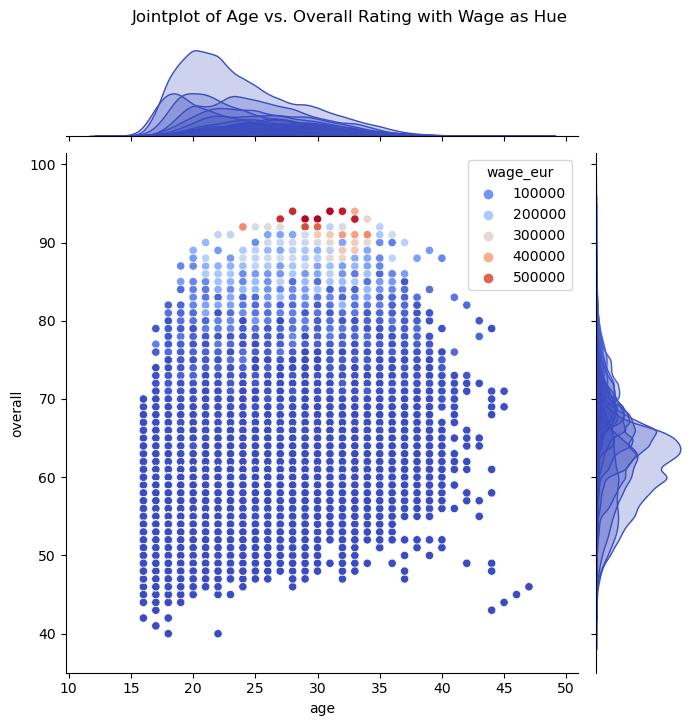

In [24]:
sns.jointplot(x='age', y='overall', data=df, hue='wage_eur', palette='coolwarm', kind='scatter', height=7)
plt.suptitle('Jointplot of Age vs. Overall Rating with Wage as Hue', y=1.03)
plt.show()

**JointPlot of Age and Overall Rating**

The scatter plot reveals that the highest wages are predominantly given to players in their late 20s to early 30s who have overall ratings around 90. Additionally, there is a general trend where both wages and overall ratings peak around this age range, highlighting the prime years of a football player's career.

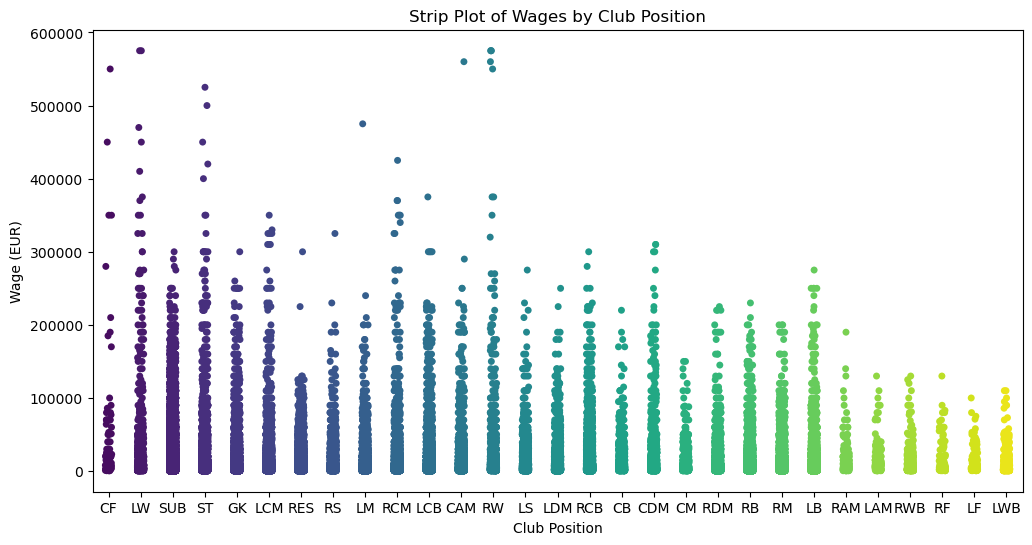

In [25]:
plt.figure(figsize=(12, 6))
sns.stripplot(x='club_position', y='wage_eur', data=df, jitter=True, palette='viridis')
plt.xlabel('Club Position')
plt.ylabel('Wage (EUR)')
plt.title('Strip Plot of Wages by Club Position')
plt.show()

The strip plot indicates that central forwards (CF), left wingers (LW), and substitutes (SUB) tend to have the highest wages among all club positions, with some reaching up to 600,000 EUR. In contrast, left-wing backs (LWB) and right-wing backs (RWB) generally earn lower wages, highlighting a significant disparity in pay based on playing positions.

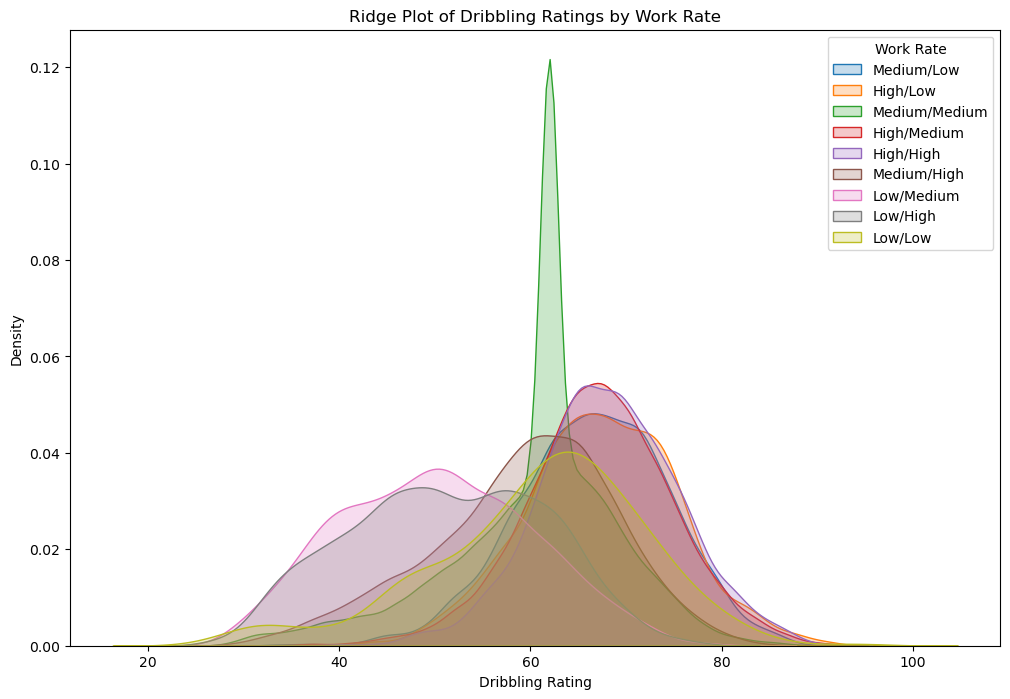

In [26]:
plt.figure(figsize=(12, 8))

work_rates = df['work_rate'].unique()
for wr in work_rates:
    subset = df[df['work_rate'] == wr]
    sns.kdeplot(subset['dribbling'], label=wr, shade=True)

plt.xlabel('Dribbling Rating')
plt.ylabel('Density')
plt.title('Ridge Plot of Dribbling Ratings by Work Rate')
plt.legend(title='Work Rate')
plt.show()


**Ridge Plot of Dribbling Rating with work_rate**

The ridge plot illustrates the distribution of dribbling ratings among players, segmented by their work rate categories. Notably, the "Medium/Medium" work rate category exhibits a pronounced peak, suggesting a higher density of players with average dribbling ratings around 60. Other work rate categories show more spread-out distributions, with varying densities, indicating a broader range of dribbling skills across different work rates. This visualization highlights the diversity in dribbling ability linked to players' work rates.

In [27]:
# Mapping of Categorical Columns with integers

# Get unique values from columns       
unique_leagues = df['league_name'].unique()
unique_positions = df['club_position'].unique()
unique_nationalities = df['nationality_name'].unique()
unique_work_rates = df['work_rate'].unique()
unique_body_types = df['body_type'].unique()
unique_short_names = df['short_name'].unique()
unique_long_names = df['long_name'].unique()
unique_player_positions = df['player_positions'].unique()
unique_club_names = df['club_name'].unique()

# Create a dictionary mapping each unique value to an integer
leagues_mapping = {league: i for i, league in enumerate(unique_leagues)}
positions_mapping = {league: i for i, league in enumerate(unique_positions)}
nationalities_mapping = {league: i for i, league in enumerate(unique_nationalities)}
work_rates_mapping = {league: i for i, league in enumerate(unique_work_rates)}
body_types_mapping = {league: i for i, league in enumerate(unique_body_types)}
short_name_mapping = {league: i for i, league in enumerate(unique_short_names)}
long_name_mapping = {league: i for i, league in enumerate(unique_long_names)}
player_positions_mapping = {league: i for i, league in enumerate(unique_player_positions)}
club_names_mapping = {league: i for i, league in enumerate(unique_club_names)}

real_face_mapping = {"Yes": 1, "No": 0}
preferred_foot_mapping = {"Left": 0, "Right": 1}

# Apply the mapping to the DataFrame columns to mapp their values
df['league_name'] = df['league_name'].map(leagues_mapping)
df['nationality_name'] = df['nationality_name'].map(nationalities_mapping)
df['club_position'] = df['club_position'].map(positions_mapping)
df['work_rate'] = df['work_rate'].map(work_rates_mapping)
df['body_type'] = df['body_type'].map(body_types_mapping)
df['real_face'] = df['real_face'].map(real_face_mapping)
df['short_name'] = df['short_name'].map(short_name_mapping)
df['long_name'] = df['long_name'].map(long_name_mapping)
df['preferred_foot'] = df['preferred_foot'].map(preferred_foot_mapping)
df['player_positions'] = df['player_positions'].map(player_positions_mapping)
df['club_name'] = df['club_name'].map(club_names_mapping)


In [28]:
df.head(5)

,player_id,fifa_version,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,league_id,league_name,league_level,club_team_id,club_name,club_position,club_jersey_number,club_contract_valid_until_year,nationality_id,nationality_name,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,fifa_update_year,birth_year,club_joined_year
0,158023,15,0,0,0,93,95,100500000.0,550000.0,27,169,67,53.0,0,1.0,241.0,0,0,10.0,2018.0,52,0,0,3,4,5,0,0,1,93.00000,89.000000,86.000000,96.000000,27.0000,63.000000,84,94,71,89,85,96,89,90,76,96,96,90,94,94,95,80,73,77,60,88,48,22,92,90,76,25,21,20,6,11,15,14,8,92,92,92,95,93,93,93,95,95,95,95,93,82,82,82,93,65,65,65,65,65,57,48,48,48,57,18,2014,1987,2004
1,20801,15,1,1,1,92,92,79000000.0,375000.0,29,185,80,53.0,0,1.0,243.0,1,1,7.0,2018.0,38,1,1,4,5,5,1,1,1,93.00000,93.000000,81.000000,91.000000,32.0000,79.000000,83,95,86,82,87,93,88,79,72,92,91,94,93,90,63,94,94,89,79,93,63,24,91,81,85,22,31,23,7,11,15,14,11,92,92,92,92,92,92,92,92,92,92,92,90,80,80,80,90,66,66,66,66,66,60,55,55,55,60,19,2014,1985,2009
2,9014,15,2,2,2,90,90,54500000.0,275000.0,30,180,80,19.0,1,1.0,21.0,2,2,10.0,2017.0,34,2,0,2,4,5,1,2,1,93.00000,86.000000,83.000000,92.000000,32.0000,64.000000,80,85,50,86,86,93,85,83,76,90,93,93,93,89,91,86,61,78,65,90,47,39,89,84,80,29,26,26,10,8,11,5,15,87,87,87,90,90,90,90,90,90,90,90,90,81,81,81,90,67,67,67,67,67,58,49,49,49,58,17,2014,1984,2009
3,41236,15,3,3,3,90,90,52500000.0,275000.0,32,195,95,16.0,2,1.0,73.0,3,3,10.0,2016.0,46,3,1,4,4,5,0,1,1,76.00000,91.000000,81.000000,86.000000,34.0000,86.000000,76,91,76,84,92,88,80,80,76,90,74,77,86,85,41,93,72,78,93,88,84,20,86,83,91,25,41,27,13,15,10,9,12,90,90,90,87,89,89,89,87,89,89,89,86,79,79,79,86,64,68,68,68,64,59,58,58,58,59,20,2014,1981,2012
4,167495,15,4,4,4,90,90,63500000.0,300000.0,28,193,92,19.0,1,1.0,21.0,2,4,1.0,2019.0,21,4,1,4,1,5,2,1,1,67.91981,52.079751,56.872836,61.950544,51.2365,64.856413,25,25,25,42,25,25,25,25,41,31,58,61,43,89,35,42,78,44,83,25,29,30,25,20,37,25,25,25,87,85,92,90,86,41,41,41,39,40,40,40,39,39,39,39,41,39,39,39,41,39,43,43,43,39,39,41,41,41,39,90,2014,1986,2011


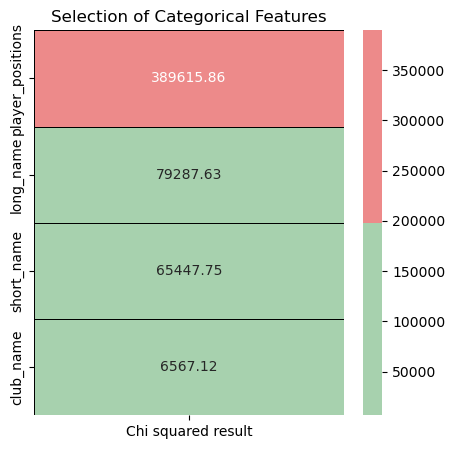

In [29]:
# Applying Chi-Square test to find importance of columns in predicting target column
# Define the categorical features and target variable
categorical_features = ['short_name', 'long_name', 'player_positions', 'club_name']
features = df.loc[:, categorical_features]
target = df.loc[:, 'preferred_foot']

# Initialize SelectKBest with chi-squared scoring function
best_features = SelectKBest(score_func=chi2, k='all')

# Fit SelectKBest to the features and target variable
fit = best_features.fit(features, target)

# Create a DataFrame to store chi-squared scores
featuresScores = pd.DataFrame(data=fit.scores_, index=list(categorical_features), columns=['Chi squared result'])

# Plot the heatmap of chi-squared scores
plt.subplots(figsize=(5, 5))
sns.heatmap(featuresScores.sort_values(ascending=False, by='Chi squared result'), 
            annot=True, cmap=['#a7d1ae', '#ed8a8a'], linewidths=0.4, linecolor='black', fmt='.2f')
plt.title('Selection of Categorical Features')
plt.show()

In [30]:
# As we see from above result that club_name has lowest importance so we have to drop this column and short and long 
# name both have almost same type of data so we drop short_name column.
df=df.drop(['short_name','club_name'],axis=1)

In [31]:
df['preferred_foot'].value_counts()

preferred_foot
1    114271
0     34777
Name: count, dtype: int64

In [35]:

# # Check class imbalance
# print("Class Distribution Before SMOTE:")
# print(df['preferred_foot'].value_counts())

# # Separate features and target variable
# X = df.drop('preferred_foot', axis=1)
# y = df['preferred_foot']

# # Apply SMOTE to balance the classes
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y)

# # Check class distribution after SMOTE
# print("\nClass Distribution After SMOTE:")
# print(y_resampled.value_counts())


In [36]:
df.head()

,player_id,fifa_version,long_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,league_id,league_name,league_level,club_team_id,club_position,club_jersey_number,club_contract_valid_until_year,nationality_id,nationality_name,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,fifa_update_year,birth_year,club_joined_year
0,158023,15,0,0,93,95,100500000.0,550000.0,27,169,67,53.0,0,1.0,241.0,0,10.0,2018.0,52,0,0,3,4,5,0,0,1,93.00000,89.000000,86.000000,96.000000,27.0000,63.000000,84,94,71,89,85,96,89,90,76,96,96,90,94,94,95,80,73,77,60,88,48,22,92,90,76,25,21,20,6,11,15,14,8,92,92,92,95,93,93,93,95,95,95,95,93,82,82,82,93,65,65,65,65,65,57,48,48,48,57,18,2014,1987,2004
1,20801,15,1,1,92,92,79000000.0,375000.0,29,185,80,53.0,0,1.0,243.0,1,7.0,2018.0,38,1,1,4,5,5,1,1,1,93.00000,93.000000,81.000000,91.000000,32.0000,79.000000,83,95,86,82,87,93,88,79,72,92,91,94,93,90,63,94,94,89,79,93,63,24,91,81,85,22,31,23,7,11,15,14,11,92,92,92,92,92,92,92,92,92,92,92,90,80,80,80,90,66,66,66,66,66,60,55,55,55,60,19,2014,1985,2009
2,9014,15,2,2,90,90,54500000.0,275000.0,30,180,80,19.0,1,1.0,21.0,2,10.0,2017.0,34,2,0,2,4,5,1,2,1,93.00000,86.000000,83.000000,92.000000,32.0000,64.000000,80,85,50,86,86,93,85,83,76,90,93,93,93,89,91,86,61,78,65,90,47,39,89,84,80,29,26,26,10,8,11,5,15,87,87,87,90,90,90,90,90,90,90,90,90,81,81,81,90,67,67,67,67,67,58,49,49,49,58,17,2014,1984,2009
3,41236,15,3,3,90,90,52500000.0,275000.0,32,195,95,16.0,2,1.0,73.0,3,10.0,2016.0,46,3,1,4,4,5,0,1,1,76.00000,91.000000,81.000000,86.000000,34.0000,86.000000,76,91,76,84,92,88,80,80,76,90,74,77,86,85,41,93,72,78,93,88,84,20,86,83,91,25,41,27,13,15,10,9,12,90,90,90,87,89,89,89,87,89,89,89,86,79,79,79,86,64,68,68,68,64,59,58,58,58,59,20,2014,1981,2012
4,167495,15,4,4,90,90,63500000.0,300000.0,28,193,92,19.0,1,1.0,21.0,4,1.0,2019.0,21,4,1,4,1,5,2,1,1,67.91981,52.079751,56.872836,61.950544,51.2365,64.856413,25,25,25,42,25,25,25,25,41,31,58,61,43,89,35,42,78,44,83,25,29,30,25,20,37,25,25,25,87,85,92,90,86,41,41,41,39,40,40,40,39,39,39,39,41,39,39,39,41,39,43,43,43,39,39,41,41,41,39,90,2014,1986,2011


In [42]:
# Separate features and target variable
X = df.drop('value_eur', axis=1)
y = np.array(df['value_eur']).reshape(-1,1)

In [43]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [44]:
scaler = StandardScaler()
y_scaler=StandardScaler()
# Fit the scaler on the training data and transform both training and validation data
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train)

X_test_scaled = scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

In [45]:
input_shape = (X_train_scaled.shape[1],)  

In [53]:
# Define the model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=input_shape),
    Dropout(0.3),  # Adding dropout for regularization
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1) 
])

In [54]:
# Compile the model with a custom optimizer for regression
optimizer = Adam(learning_rate=0.001)  # Adjust learning rate if needed
model.compile(optimizer=optimizer,
              loss='mean_squared_error', 
              metrics=['r2_score'])  

In [55]:
# Train the model
history = model.fit(X_train_scaled, y_train_scaled,
                    epochs=10,  # Number of training epochs
                    batch_size=32,  # Batch size
                    validation_data=(X_test_scaled, y_test_scaled))  # Validation data

Epoch 1/10
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 0.3669 - r2_score: 0.6192 - val_loss: 0.2108 - val_r2_score: 0.7761
Epoch 2/10
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.2144 - r2_score: 0.7935 - val_loss: 0.1350 - val_r2_score: 0.8566
Epoch 3/10
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.2204 - r2_score: 0.7836 - val_loss: 0.1736 - val_r2_score: 0.8156
Epoch 4/10
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.1892 - r2_score: 0.8119 - val_loss: 0.2236 - val_r2_score: 0.7625
Epoch 5/10
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.1641 - r2_score: 0.8294 - val_loss: 0.0868 - val_r2_score: 0.9078
Epoch 6/10
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.1740 - r2_score: 0.8224 - val_loss: 0.2436 - val_r2_score: 0.7413
Epoch 7/10
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.1794 - r2_score: 0.8294 - val_loss: 0.1364 - val_r2_score: 0.8552
Epoch 8/10
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.1779 - r2_score: 0

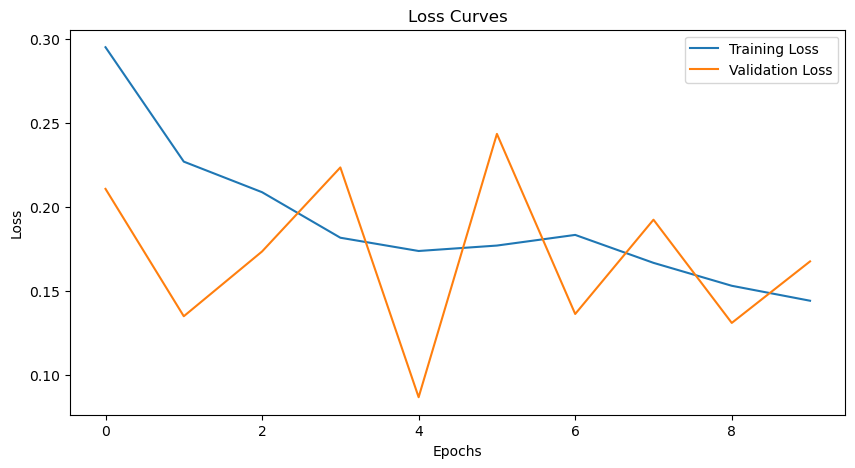

In [56]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [84]:
# Predict on test data
y_pred = model.predict(X_test_scaled)

932/932 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [85]:
r2_score(y_test_scaled,y_pred)

0.8219232880621663

In [86]:
metric_dic={"R2_score_MLP":r2_score(y_test_scaled,y_pred),
           "MAE_MLP":mean_absolute_error(y_test_scaled,y_pred),
           "MSE_MLP":mean_squared_error(y_test_scaled,y_pred)}

In [87]:
metric_dic

{'R2_score_MLP': 0.8219232880621663,
 'MAE_MLP': 0.12428492782453998,
 'MSE_MLP': 0.16766251707300295}

In [76]:
# Define the 1D CNN model
cnn_model = Sequential()

# Add a 1D convolutional layer
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))

# Add another convolutional layer (optional)
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))

# Flatten the output from the convolutional layers
cnn_model.add(Flatten())

# Add a dense layer
cnn_model.add(Dense(64, activation='relu'))

# Add the output layer for regression
cnn_model.add(Dense(1))

In [79]:
# Compile the model with a custom optimizer for regression
optimizer = Adam(learning_rate=0.001)  # Adjust learning rate if needed
cnn_model.compile(optimizer=optimizer,
              loss='mean_squared_error', 
              metrics=['r2_score']) 

In [80]:
# Train the model
cnn_history = cnn_model.fit(X_train_scaled, y_train_scaled,
                    epochs=10,  # Number of training epochs
                    batch_size=32,  # Batch size
                    validation_data=(X_test_scaled, y_test_scaled))  # Validation data

Epoch 1/10
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 45s 11ms/step - loss: 0.1067 - r2_score: 0.8908 - val_loss: 0.0601 - val_r2_score: 0.9362
Epoch 2/10
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 0.0648 - r2_score: 0.9348 - val_loss: 0.0386 - val_r2_score: 0.9590
Epoch 3/10
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0461 - r2_score: 0.9534 - val_loss: 0.0376 - val_r2_score: 0.9601
Epoch 4/10
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0406 - r2_score: 0.9575 - val_loss: 0.0314 - val_r2_score: 0.9666
Epoch 5/10
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0372 - r2_score: 0.9626 - val_loss: 0.0465 - val_r2_score: 0.9506
Epoch 6/10
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0389 - r2_score: 0.9612 - val_loss: 0.0257 - val_r2_score: 0.9727
Epoch 7/10
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0292 - r2_score: 0.9718 - val_loss: 0.0458 - val_r2_score: 0.9514
Epoch 8/10
3727/3727 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0283 - r2_

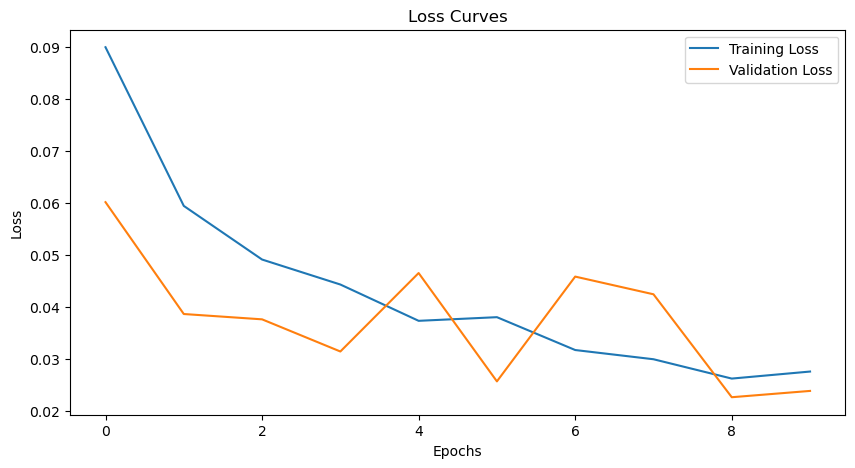

In [81]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [88]:
# Predict on test data
y_pred = cnn_model.predict(X_test_scaled)

932/932 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


In [89]:
metric_dic["R2_score_CNN"]=r2_score(y_test_scaled,y_pred)
metric_dic["MAE_CNN"]=mean_absolute_error(y_test_scaled,y_pred)
metric_dic[ "MSE_CNN"]=mean_squared_error(y_test_scaled,y_pred)

In [91]:
metric_dic

{'R2_score_MLP': 0.8219232880621663,
 'MAE_MLP': 0.12428492782453998,
 'MSE_MLP': 0.16766251707300295,
 'R2_score_CNN': 0.9746974147118845,
 'MAE_CNN': 0.056325010065083926,
 'MSE_CNN': 0.02382285191418379}

In [94]:
results_df = pd.DataFrame([metric_dic])

In [95]:
results_df

,R2_score_MLP,MAE_MLP,MSE_MLP,R2_score_CNN,MAE_CNN,MSE_CNN
0,0.821923,0.124285,0.167663,0.974697,0.056325,0.023823


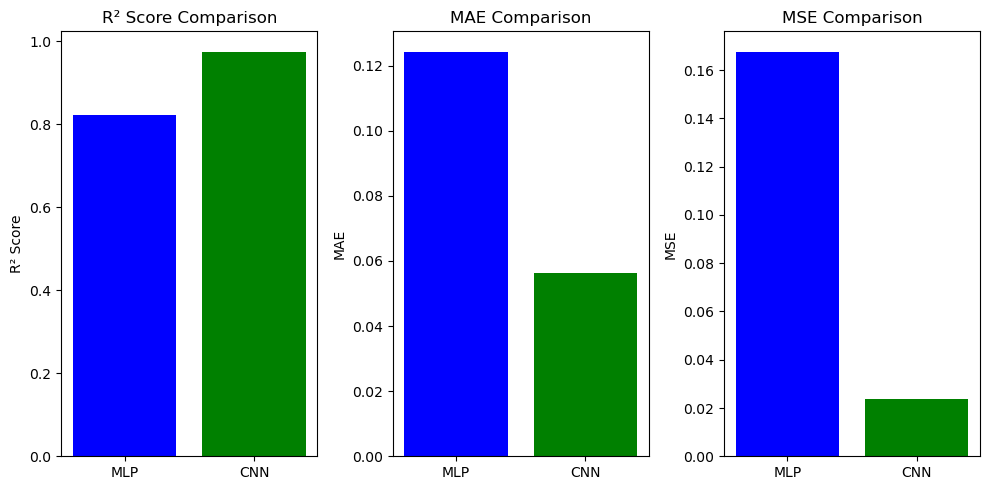

In [97]:
# Extract metrics for plotting
r2_scores = [metric_dic['R2_score_MLP'], metric_dic['R2_score_CNN']]
mae_scores = [metric_dic['MAE_MLP'], metric_dic['MAE_CNN']]
mse_scores = [metric_dic['MSE_MLP'], metric_dic['MSE_CNN']]

# Define labels and positions
labels = ['MLP', 'CNN']
x = np.arange(len(labels))  # Label locations

# Plotting the R² score comparison
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.bar(x, r2_scores, color=['blue', 'green'])
plt.xticks(x, labels)
plt.ylabel('R² Score')
plt.title('R² Score Comparison')

# Plotting the MAE comparison
plt.subplot(1, 3, 2)
plt.bar(x, mae_scores, color=['blue', 'green'])
plt.xticks(x, labels)
plt.ylabel('MAE')
plt.title('MAE Comparison')

# Plotting the MSE comparison
plt.subplot(1, 3, 3)
plt.bar(x, mse_scores, color=['blue', 'green'])
plt.xticks(x, labels)
plt.ylabel('MSE')
plt.title('MSE Comparison')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()